In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.transform import resize 
import tensorflow as tf

## Load Dataset

In [2]:
datamining_dir = "./"

X_train = np.load(datamining_dir + "train_X.npy")
X_test = np.load(datamining_dir + "test_X.npy")
y_train = np.load(datamining_dir + "train_Y.npy")
y_test = np.load(datamining_dir + "test_Y.npy")

print("X_train shape ", X_train.shape)
print("y_train shape ", y_train.shape)
print("X_test shape ", X_test.shape)
print("y_test shape ", y_test.shape)

X_train shape  (16653, 64, 64)
y_train shape  (16653,)
X_test shape  (4163, 64, 64)
y_test shape  (4163,)


## Display few images

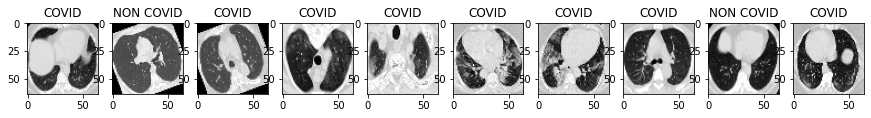

In [3]:
fig, axes = plt.subplots(1,10,figsize=(15,15))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title("COVID" if y_train[i] == 0 else "NON COVID")

## Flattening images for PCA

In [3]:
dims = 64
flatten_X_train = X_train.reshape(X_train.shape[0], dims*dims)
flatten_X_test = X_test.reshape(X_test.shape[0], dims*dims)

print(flatten_X_train.shape)
print(flatten_X_test.shape)

(16653, 4096)
(4163, 4096)


## PCA

In [4]:
pca = PCA(n_components=0.7)

pca.fit(flatten_X_train)

PCA(n_components=0.7)

## Display Eigenimages for PCA

(19, 4096)


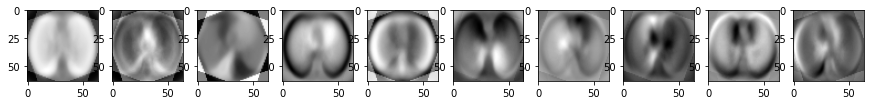

In [5]:
print(pca.components_.shape)
fig, axes = plt.subplots(1,10,figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(dims,dims), cmap="gray")

## Inverse transform images to get reduced train and test set

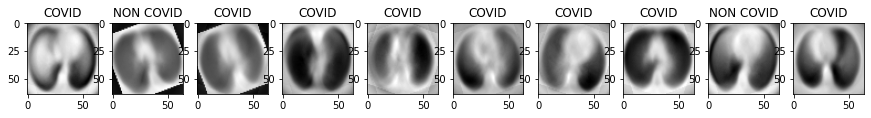

In [6]:
components = pca.transform(flatten_X_train)
X_reduced = pca.inverse_transform(components)
X_train_imgs = X_reduced.reshape(X_train.shape[0], dims, dims)

fig, axes = plt.subplots(1,10,figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_imgs[i], cmap='gray')
    ax.set_title("COVID" if y_train[i] == 0 else "NON COVID")
    
X_train_imgs = np.stack((X_train_imgs, X_train_imgs, X_train_imgs), axis=3)

test_components = pca.transform(flatten_X_test)
X_test_reduced = pca.inverse_transform(test_components)
X_test_imgs = X_test_reduced.reshape(X_test.shape[0], dims, dims)

X_test_imgs = np.stack((X_test_imgs, X_test_imgs, X_test_imgs), axis=3)

## Preparing Model

In [7]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
import keras

resnet = ResNet50(include_top=False, input_shape=(dims, dims, 3))

for layer in resnet.layers:
    layer.trainable = False

In [8]:
dnn = tf.keras.layers.Flatten()(resnet.output)
dnn = tf.keras.layers.Dense(512, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(1, activation='sigmoid')(dnn)

model = Model(resnet.input, dnn)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 27,979,905
Trainable params: 4,392,193
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None


## Training

In [9]:
hist = model.fit(X_train_imgs, y_train, validation_split=0.2, epochs=10, steps_per_epoch = 100)

Epoch 1/10
100/100 [==============================] - 116s 1s/step - loss: 0.7830 - acc: 0.6192 - val_loss: 0.5864 - val_acc: 0.6809
Epoch 2/10
100/100 [==============================] - 107s 1s/step - loss: 0.5341 - acc: 0.7294 - val_loss: 0.5572 - val_acc: 0.6950
Epoch 3/10
100/100 [==============================] - 109s 1s/step - loss: 0.4987 - acc: 0.7491 - val_loss: 0.5753 - val_acc: 0.7049
Epoch 4/10
100/100 [==============================] - 109s 1s/step - loss: 0.4606 - acc: 0.7765 - val_loss: 0.5059 - val_acc: 0.7451
Epoch 5/10
100/100 [==============================] - 111s 1s/step - loss: 0.4077 - acc: 0.8111 - val_loss: 0.4667 - val_acc: 0.7736
Epoch 6/10
100/100 [==============================] - 122s 1s/step - loss: 0.3794 - acc: 0.8296 - val_loss: 0.4695 - val_acc: 0.7691
Epoch 7/10
100/100 [==============================] - 135s 1s/step - loss: 0.3558 - acc: 0.8428 - val_loss: 0.4467 - val_acc: 0.7941
Epoch 8/10
100/100 [==============================] - 129s 1s/step - 

## Evaluating

In [10]:
model.evaluate(X_test_imgs, y_test)

131/131 [==============================] - 29s 222ms/step - loss: 0.3833 - acc: 0.8323


[0.38332220911979675, 0.83233243227005]

## Plotting Loss

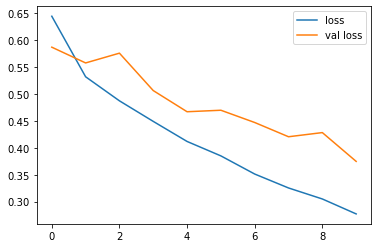

In [11]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()

## Plotting Accuracy

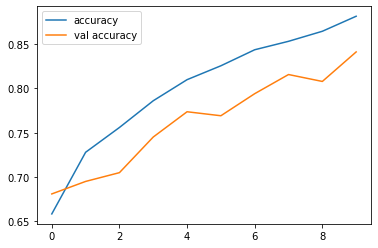

In [12]:
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val accuracy')
plt.legend()